## Business Problem
The streaming service is seeing high unsubscribing since users spend more time scrolling for something to watch than actually watching movies.

## Goal
Increase user engagement and retention by implementing a personalized recommendation engine that reduces "choice paralysis" by presenting a curated "Top 5" list for every user.

## Objectives
1. Develop a Collaborative Filtering Model: Build and tune a model that predicts user ratings for unseen movies with high accuracy.

2. Minimize Prediction Error: Achieve a target RMSE (Root Mean Squared Error) below a specific threshold (typically < 0.90 on this dataset) to ensure recommendations are reliable.

3. Deploy a Recommendation Function: Create a Python function that accepts a UserID and returns the top 5 movie titles they are most likely to enjoy, filtering out movies they have already seen.

In [1]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy


### 1. Loading data and EDA

In [2]:
# Load the movies df
movies_df = pd.read_csv("./Data/movies.csv")
print(movies_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


In [3]:
# Load the ratings df
ratings_df = pd.read_csv("./Data/ratings.csv")
print(ratings_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


In [4]:
# drop the unnecessary timestamp column
ratings_df = ratings_df.drop(columns='timestamp')

In [5]:
# merge ratings and movies csv's
merged_df = pd.merge(movies_df, ratings_df, on='movieId', how='outer')
merged_df.head()
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100854 entries, 0 to 100853
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   movieId  100854 non-null  int64  
 1   title    100854 non-null  object 
 2   genres   100854 non-null  object 
 3   userId   100836 non-null  float64
 4   rating   100836 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.6+ MB


In [6]:
merged_df.isna().sum()

movieId     0
title       0
genres      0
userId     18
rating     18
dtype: int64

In [7]:
merged_df = merged_df.dropna()

In [8]:
merged_df.duplicated().sum()

0

In [9]:
merged_df.isna().sum()

movieId    0
title      0
genres     0
userId     0
rating     0
dtype: int64

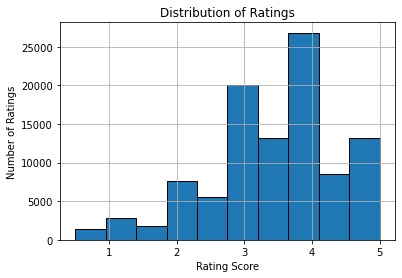

In [10]:
# how the ratings are done
import matplotlib.pyplot as plt

merged_df['rating'].hist(bins=10, edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating Score')
plt.ylabel('Number of Ratings')
plt.show()

In [11]:
# The descriptive statistics of the merged df
print(ratings_df.groupby('userId').size().describe())
print(ratings_df.groupby('movieId').size().describe())


count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
dtype: float64
count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
dtype: float64


#### User Activity Stats;
- There are 610 users
- Each user has rates atleast 20 movies and and there is a user who rated 2698 moives!
- Half of the users have rated fewer than 70 movies, while the other half are much more active.

#### Movie Popularity Stats
- There are 9724 movies
- There are many movies that have been rated by exactly one person.
- The most popular movie has 329 ratings.
- The 25th percentile is 1 and the median is only 3. Half of all the movies in the database have 3 or fewer ratings.

In [12]:
# Most popular movies by rating
# Group by title and calculate count and mean
stats = merged_df.groupby('title')['rating'].agg(['count', 'mean'])

# Filter for movies with more than 100 ratings to avoid low watched movies
popular_movies = stats[stats['count'] > 100].sort_values('count', ascending=False)
print(popular_movies.head(10))

                                           count      mean
title                                                     
Forrest Gump (1994)                          329  4.164134
Shawshank Redemption, The (1994)             317  4.429022
Pulp Fiction (1994)                          307  4.197068
Silence of the Lambs, The (1991)             279  4.161290
Matrix, The (1999)                           278  4.192446
Star Wars: Episode IV - A New Hope (1977)    251  4.231076
Jurassic Park (1993)                         238  3.750000
Braveheart (1995)                            237  4.031646
Terminator 2: Judgment Day (1991)            224  3.970982
Schindler's List (1993)                      220  4.225000


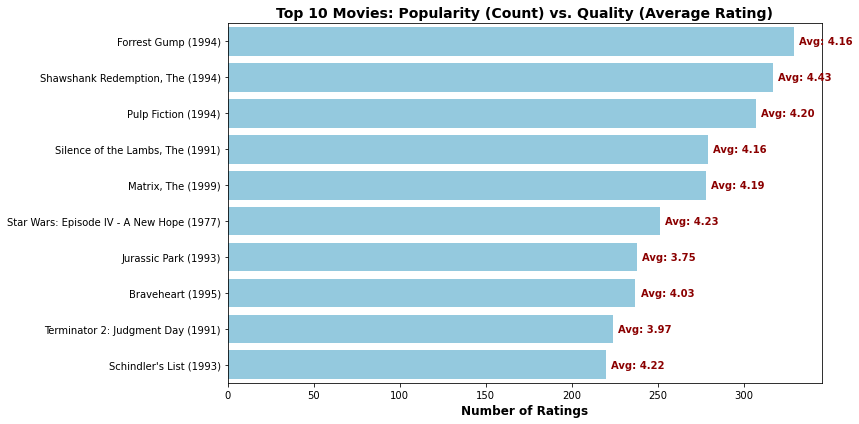

In [13]:
# Top 10 movies by count
fig, ax1 = plt.subplots(figsize=(12, 6))

top_10 = stats.sort_values('count', ascending=False).head(10)
top_10_plot = top_10.reset_index()
# Subplot 1: Count
color_count = 'skyblue'
sns.barplot(data=top_10_plot, x='count', y='title', ax=ax1, color=color_count)
ax1.set_title('Top 10 Movies: Popularity (Count) vs. Quality (Average Rating)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Ratings', fontsize=12, fontweight='bold')
ax1.set_ylabel('')

# Adding text labels for the mean on the same plot for a combined look
for i, p in enumerate(ax1.patches):
    width = p.get_width()
    ax1.text(width + 3, p.get_y() + p.get_height() / 2,
             f"Avg: {top_10['mean'].iloc[i]:.2f}",
             va='center', fontsize=10, fontweight='bold', color='darkred')

plt.tight_layout()

### 2 Creating the best model
#### Develop a collaborative filtering model

In [14]:
# create a collaborative filtering dataset
# read in values as Surprise dataset 
reader = Reader()
data = Dataset.load_from_df(ratings_df, reader)
data

In [15]:
# Check the number of users and items in the df
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users)
print('Number of items: ', dataset.n_items)


Number of users:  610
Number of items:  9724


In [16]:
#  Prepare the data for Surprise
# The Reader expects columns in this specific order: user, item, rating
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df, reader)

# Split into training and testing sets (80/20)
trainset, testset = train_test_split(data, test_size=0.2)


In [17]:
# Baseline Model KNN (User-Based Collaborative Filtering)
# This looks for "Users similar to you"
sim_options = {'name': 'pearson', 'user_based': True}
knn_model = KNNBasic(sim_options=sim_options)
knn_model.fit(trainset)
knn_predictions = knn_model.test(testset)

# Evaluation
print(f"KNN RMSE: {accuracy.rmse(knn_predictions):.4f}")
print("--------------------------------------------")
print(f"KNN MAE: {accuracy.mae(knn_predictions):.4f}")

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9678
KNN RMSE: 0.9678
--------------------------------------------
MAE:  0.7460
KNN MAE: 0.7460


In [18]:
# SVD (Matrix Factorization) ---
# This is what Netflix famously used. It finds hidden "latent factors"
svd_model = SVD()
svd_model.fit(trainset)
svd_predictions = svd_model.test(testset)

# Evaluation
print(f"SVD RMSE: {accuracy.rmse(svd_predictions):.4f}")
print("--------------------------------------------")
print(f"SVD MAE: {accuracy.mae(svd_predictions):.4f}")


RMSE: 0.8663
SVD RMSE: 0.8663
--------------------------------------------
MAE:  0.6649
SVD MAE: 0.6649


In [19]:
# GridsearchCV for hyperparameter tuning
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_factors': [20, 50, 100],
    'reg_all': [0.05, 0.1, 0.2],
    'lr_all': [0.002, 0.005, 0.01]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs.fit(data)

print(f"Best RMSE: {gs.best_score['rmse']}")
print(f"Best MAE Score:  {gs.best_score['mae']}")
print(f"Best Params: {gs.best_params['rmse']}")
print(f"Best Params (MAE):  {gs.best_params['mae']}")

Best RMSE: 0.8672977591905066
Best MAE Score:  0.6654346745012606
Best Params: {'n_factors': 100, 'reg_all': 0.05, 'lr_all': 0.01}
Best Params (MAE):  {'n_factors': 100, 'reg_all': 0.05, 'lr_all': 0.01}


In [24]:
#  Get the best parameters
best_params = gs.best_params['rmse']

# 2. Create a final model using those exact settings
final_model = SVD(n_factors=best_params['n_factors'], 
                  reg_all=best_params['reg_all'])

#  Fit it on the ENTIRE dataset so it's ready for recommendations
trainset = data.build_full_trainset()
final_model.fit(trainset)

In [20]:
# # Attempting to lower the rmse further
# from surprise import SVDpp

# # SVD++ is computationally expensive, so we use a smaller grid
# param_grid_pp = {
#     'n_factors': [20, 50],
#     'reg_all': [0.05, 0.1],
#     'n_epochs': [5] 
# }

# gs_pp = GridSearchCV(SVDpp, param_grid_pp, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
# gs_pp.fit(data)

# print(f"SVD++ Best RMSE: {gs_pp.best_score['rmse']}")
# print(f"SVD++ Best MAE:  {gs_pp.best_score['mae']}")

In [21]:
# Deploy a recommendation function
def get_top_5_recommendations(user_id, model, movies_df, ratings_df):
    """
    Returns the top 5 movie titles for a given user based on SVD predictions.
    """
    #  Get IDs of all movies the user has seen
    seen_movie_ids = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    
    #  Get IDs of all movies in the data
    all_movie_ids = movies_df['movieId'].unique()
    
    #  Filter out seen movies to get 'unseen' list
    unseen_movie_ids = [m_id for m_id in all_movie_ids if m_id not in seen_movie_ids]
    
    #  Predict ratings for all unseen movies
    # model.predict returns an object; we extract the 'est' (estimated rating)
    predictions = [model.predict(user_id, m_id) for m_id in unseen_movie_ids]
    
    #  Sort predictions by estimated rating in descending order
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    #  Take top 5 predictions
    top_5_preds = predictions[:5]
    
    #  Map movieIds back to Titles for the final output
    top_5_titles = []
    for pred in top_5_preds:
        title = movies_df[movies_df['movieId'] == pred.iid]['title'].values[0]
        top_5_titles.append((title, round(pred.est, 2)))
        
    return top_5_titles

# --- HOW TO USE IT ---
# Replace 'gs.best_estimator['rmse']' with your actual trained SVD object
best_model = gs.best_estimator['rmse'] 
trainset = data.build_full_trainset()
best_model.fit(trainset)
user_to_check = 1


recommendations = get_top_5_recommendations(user_to_check, best_model, movies_df, ratings_df)

print(f"Top 5 Recommendations for User {user_to_check}:")
for i, (title, score) in enumerate(recommendations, 1):
    print(f"{i}. {title} (Predicted Score: {score})")

Top 5 Recommendations for User 1:
1. Shawshank Redemption, The (1994) (Predicted Score: 5.0)
2. In the Name of the Father (1993) (Predicted Score: 5.0)
3. Godfather, The (1972) (Predicted Score: 5.0)
4. Philadelphia Story, The (1940) (Predicted Score: 5.0)
5. North by Northwest (1959) (Predicted Score: 5.0)


In [25]:
# Look at what User 1 actually liked in the past
print(merged_df[merged_df['userId'] == 1].sort_values('rating', ascending=False).head(5))

       movieId                                      title  \
65538     5060               M*A*S*H (a.k.a. MASH) (1970)   
48950     2872                           Excalibur (1981)   
29326     1291  Indiana Jones and the Last Crusade (1989)   
29561     1298                Pink Floyd: The Wall (1982)   
49666     2948               From Russia with Love (1963)   

                          genres  userId  rating  
65538           Comedy|Drama|War     1.0     5.0  
48950          Adventure|Fantasy     1.0     5.0  
29326           Action|Adventure     1.0     5.0  
29561              Drama|Musical     1.0     5.0  
49666  Action|Adventure|Thriller     1.0     5.0  


In [27]:
# 1. Group by userId and count their ratings
user_counts = ratings_df['userId'].value_counts()

# 2. Find users with very few ratings (e.g., between 10 and 15)
# This ensures they have enough history for SVD to guess, but not enough to be 'easy'
niche_users = user_counts[(user_counts >= 20) & (user_counts <= 30)].index.tolist()

if len(niche_users) > 0:
    target_niche_user = niche_users[0]
    print(f"Testing for Niche User ID: {target_niche_user}")
    
    # See what they liked (to compare later)
    user_history = merged_df[merged_df['userId'] == target_niche_user].sort_values('rating', ascending=False)
    print("\nUser's Top Rated Movies:")
    print(user_history[['title', 'genres', 'rating']].head(5))
    
    # 3. Get recommendations
    recommendations = get_top_5_recommendations(target_niche_user, best_model, movies_df, ratings_df)
    
    print(f"\nTop 5 Recommendations for User {target_niche_user}:")
    for i, (title, score) in enumerate(recommendations, 1):
        print(f"{i}. {title} (Predicted: {score})")
else:
    print("No users found with that specific rating count. Try expanding the range (e.g., 5 to 20).")

Testing for Niche User ID: 363

User's Top Rated Movies:
                                                    title  \
34845                            Good Will Hunting (1997)   
8052                                  Pulp Fiction (1994)   
98392                    Guardians of the Galaxy 2 (2017)   
25122   Raiders of the Lost Ark (Indiana Jones and the...   
100339                                       Logan (2017)   

                             genres  rating  
34845                 Drama|Romance     5.0  
8052    Comedy|Crime|Drama|Thriller     5.0  
98392       Action|Adventure|Sci-Fi     5.0  
25122              Action|Adventure     4.0  
100339                Action|Sci-Fi     4.0  

Top 5 Recommendations for User 363:
1. Life Is Beautiful (La Vita è bella) (1997) (Predicted: 4.26)
2. Guess Who's Coming to Dinner (1967) (Predicted: 4.24)
3. Gallipoli (1981) (Predicted: 4.21)
4. Grand Day Out with Wallace and Gromit, A (1989) (Predicted: 4.18)
5. Yojimbo (1961) (Predicted: 4.11)